# 一维Euler方程
- 参考：Toro, E. F. (2009). Riemann solvers and numerical methods for fluid dynamics: A practical introduction (3rd ed.). Springer Science & Business Media. https://doi.org/10.1007/b79761
$$\frac{\partial\rm{U}}{\partial t}+\frac{\rm{f}(\rm{U})}{\partial x}=0\qquad\rm{U}=\begin{bmatrix}\rho\\\rho u\\E\end{bmatrix},\rm{f}(\rm{U})=\begin{bmatrix}\rho u\\\rho u^2+p\\u(E+p)\end{bmatrix},E=\frac{p}{\gamma-1}+\frac{\rho u^2}{2} $$
$$\rm{A}=\frac{\partial\rm{f}(\rm{U})}{\partial\rm{U}}=\begin{bmatrix}0 &1 &0\\\frac{1}{2}(\gamma-3)u^2 &(3-\gamma)u &\gamma-1\\\frac{1}{2}(\gamma-2)u^3-\frac{c^2u}{\gamma-1}&\frac{c^2}{\gamma-1}+\frac{3-\gamma}{2}u^2&\gamma u \end{bmatrix} $$
$$\lambda_1=u-c,\quad\lambda_2=u,\quad\lambda_3=u+c$$
$$\pmb{A}=\pmb{K}\pmb{\Lambda}\pmb{K}^{-1},\quad\pmb{K}=\begin{bmatrix}1 &1 &1\\u-c & u&u+c\\H-uc&\frac{1}{2}u^2 &H+uc \end{bmatrix},\quad H=\frac{E+p}{\rho}=\frac{1}{2}u^2+\frac{c^2}{\gamma-1} $$
$$\pmb{K}^{-1}=\frac{\gamma-1}{2c^2}\begin{bmatrix}\frac{1}{2}u^2+\frac{uc}{\gamma-1}&-u-\frac{c}{\gamma-1}&1\\\frac{2c^2}{\gamma-1}-u^2&2u&-2\\\frac{1}{2}u^2-\frac{uc}{\gamma-1}&\frac{c}{\gamma-1}-u&1 \end{bmatrix} $$
- Sod激波管问题：$x\in [0, 1]$，$t=0$时
$$(p,u,\rho)=\begin{cases}1,0,1& x<0.5\\0.1,0,0.125& x\le 0.5\end{cases} $$
- Shu-Osher问题：$x\in [0, 10]$，$t=0$时
$$\begin{cases}\rho=3.857143,u=2.629369,p=10.333333&x<1\\\rho=1+A\sin(\omega x),u=0,p=1&x\le 1\end{cases}$$
  其中$A=0.2$，$\omega=0.5$。

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)

In [23]:
def init_value(nx, init_type):
    '''
    Generate initial values.
    =========================
    input: nx: gird number
           init_type: Sod or Shu-Osher problem
    output: U: conservative variable, (3,nx)
            x: coordinate, (nx,)
    '''
    gamma = 1.4
    init_sod = 0          # Sod problem
    init_shu_osher = 1    # Shu-Osher problem
    U = np.zeros((3, nx)) # conservative variable
    if init_type == init_sod:
        dx = 1 / (nx - 1)
        x = np.array([i*dx for i in range(nx)]) # x in [0, 1]
        rho1 = 1; u1 = 0; p1 = 1
        rho2 = 0.125; u2 = 0; p2 = 0.1
        U[0, :int(nx/2)] = rho1 
        U[1, :int(nx/2)] = rho1*u1 
        U[2, :int(nx/2)] = p1/(gamma-1) + rho1*u1*u1/2 
        U[0, int(nx/2):] = rho2
        U[1, int(nx/2):] = rho2*u2
        U[2, int(nx/2):] = p2/(gamma-1) + rho2*u2*u2/2
    elif init_type == init_shu_osher:
        dx = 10 / (nx - 1)
        x = np.array([i*dx for i in range(nx)]) # x in [0, 10]
        rho1 = 3.857143; u1 = 2.629369; p1 = 10.333333
        u2 = 0; p2 = 1
        U[0, :] = 1 + 0.2*np.sin(5*x)
        U[0, :int(nx/10)] = rho1
        U[1, :] = (1 + 0.2*np.sin(5*x))*u2
        U[1, :int(nx/10)] = rho1*u1
        U[2, :] = p2/(gamma-1) + (1 + 0.2*np.sin(5*x))*u2*u2/2
        U[2, :int(nx/10)] = p1/(gamma-1) + rho1*u1*u1/2

    return U, x

def primitive_var(U):
    '''
    Transfer conservative variables into primitive variables.
    =========================================================
    input: U: conservative variables, (3,nx)
    output: rho, u, p, c: density, velocity, pressure, sound speed, respectively, (nx,)
    '''
    gamma = 1.4
    rho = U[0, :];
    u = U[1, :]/U[0, :]
    p = (gamma-1)*(U[2,:]-U[1,:]*u/2)
    c = np.sqrt(gamma*p/rho)

    return rho, u, p, c


def physical_flux(rho, u, p):
    '''
    Calculate physical flux f(U) to validate the flux splitting f = f^+ + f^_
    '''
    gamma = 1.4
    nx = rho.shape[0]
    fu = np.zeros((3, nx))
    fu[0, :] = rho * u
    fu[1, :] = rho * u * u + p
    E = p / (gamma - 1) + 1/2 * rho * u * u
    fu[2, :] = u * (E + p)

    return fu

## 激波捕捉格式
- 参考：李新亮，《计算流体力学》课件 (PPT) 第 4 讲
- 守恒格式
$$\frac{\partial f}{\partial x}\Big|_j=\frac{\hat{f}_{j+1/2}-\hat{f}_{j-1/2}}{\Delta x} $$
- TVD
$$\hat{f}_{j+1/2}=f_j+\phi_j(r_j)(f_{j+1}-f_j)/2\quad r_j=\frac{f_j-f_{j-1}}{f_{j+1}-f_j} $$
$$\text{Van Leer: }\phi(r)=\frac{|r|+r}{|r|+1}=\begin{cases}\frac{2r}{r+1}&r>0\\0&r\le 0 \end{cases} $$
- GVC：群速度控制格式
  - 二阶中心，快格式，波前振荡，应放到下游去
  - 二阶应分，慢格式，波后振荡，应放到上游去
  $$\hat{f}_{j+1/2}=\begin{cases}(3f_j-f_{j-1})/2&|f_j-f_{j-1}|<|f_{j+1}-f_j |\\(f_j+f_{j+1})/2&|f_j-f_{j-1} |\ge|f_{j+1}-f_j | \end{cases} $$
- MUSCL
$$f_{j+1/2}^{\rm{MUSCL3}}=f_j+\frac{s}{4}[(1-\frac{s}{3})\delta_x^-+(1+\frac{s}{3})\delta_x^+]f_j\qquad\delta^-f_j=f_j-f_{j-1},\delta^+f_j=f_{j+1}-f_j $$
$$s=\frac{2\delta^-f_j\delta^+f_j+\varepsilon}{(\delta^-f_j)^2+(\delta^+f_j)^2+\varepsilon}\qquad \varepsilon=10^{-6} $$
光滑区：$\delta^-f_j\approx\delta^+f_j\Rightarrow s\to 1\qquad f_{j+1/2}^{\rm{MUSCL3}}=(-f_{j-1}+5u_j+2u_{j+1})/6\quad\text{3阶迎风} $

非光滑区：$s\to 0\hspace{12em} f_{j+1/2}^{\rm{MUSCL3}}\to f_j\qquad\text{1阶迎风} $
- NND
$$\hat{f}_{j+1/2}=f_j+\frac{1}{2}\text{minmod}(f_j-f_{j-1},f_{j+1}-f_j) $$
- WENO5
   - 3个子模板，每个子模板4个基架点，3阶精度。按光滑度加权，都光滑逼近5阶精度(总的6个基架点)
   - 边界条件处理：用到边界外的点，模板权重设为0，效果不过，但边界降阶
   $$\hat{f}_{j+1/2}^{\rm{WENO}}=w_1\hat{f}_{j+1/2}^{(1)}+w_2\hat{f}_{j+1/2}^{(2)}+w_3\hat{f}_{j+1/2}^{(3)} $$
   $$\hat{f}_{j+1/2}^{(1)}=\frac{1}{3}f_{j-2}-\frac{7}{6}f_{j-1}+\frac{11}{6}f_j\quad \hat{f}_{j+1/2}^{(2)}=-\frac{1}{6}f_{j-1}+\frac{5}{6}f_{j}+\frac{1}{3}f_{j+1}$$
   $$\hat{f}_{j+1/2}^{(3)}=\frac{1}{3}f_{j}+\frac{5}{6}f_{j+1}-\frac{1}{6}f_{j+2}\qquad w_k=\frac{\alpha_k}{\alpha_1+\alpha_2+\alpha_3} $$
   $$\alpha_k=\frac{C_k}{(\varepsilon+IS_k)^2},\varepsilon=10^{-6}\qquad C_1=\frac{1}{10},C_2=\frac{6}{10},C_3=\frac{3}{10} $$
   $$IS_1=\frac{1}{4}(f_{j-2}-4f_{j-1}+3f_j)^2+\frac{13}{12}(f_{j-2}-2f_{j-1}+f_j)^2 $$
   $$IS_2=\frac{1}{4}(f_{j-1}-f_{j+1})^2+\frac{13}{12}(f_{j-1}-2f_{j}+f_{j+1})^2 $$
   $$IS_3=\frac{1}{4}(3f_{j}-4f_{j+1}+f_{j+2})^2+\frac{13}{12}(f_{j}-2f_{j+1}+f_{j+2})^2 $$

In [24]:
def minmod(a, b): # 同号(不为0)取绝对值小的，否则取0
    len = a.shape[1]
    temp = np.zeros((3,len))
    for i in range(3):
        for j in range(len):
            if a[i, j] * b[i, j] > 0:
                if np.abs(a[i, j]) > np.abs(b[i, j]):
                    temp[i, j] = b[i, j]
                else:
                    temp[i, j] = a[i, j]
            else:
                temp[i, j] = 0
    return temp


def NND_pos(f, KL, KR):
    '''
    NND numerical flux for positive wave speed.
    ===========================================
    input: f: f_j, (3, nx)
    output: fx: f_{j+1/2}, (3, nx)
    '''
    fx = np.zeros((3, f.shape[1]))
    fx[:,-KL:-KR] = f[:,-KL:-KR] \
        + 1/2*minmod(f[:,-KL:-KR]-f[:,-KL-1:-KR-1], f[:,-KL+1:-KR+1]-f[:,-KL:-KR])
    return fx


def NND_neg(f, KL, KR):
    '''
    NND numerical flux for negative wave speed.
    ===========================================
    input: f: flux, (3, nx)
    output: fx: f_{j+1/2}, (3, nx)
    '''
    fx = np.zeros((3, f.shape[1]))
    fx[:,-KL:-KR] = f[:,-KL+1:-KR+1] \
        + 1/2*minmod(f[:,-KL:-KR]-f[:,-KL+1:-KR+1], f[:,-KL+1:-KR+1]-f[:,-KL+2:-KR+2])
    return fx

In [25]:
def WENO5_pos(f, KL, KR):
    '''
    5 order WENO numerical flux for positve wave
    '''
    epsilon = 1e-6
    C1 = 1/10; C2 = 6/10; C3 = 3/10
    fx = np.zeros((3, f.shape[1]))

    # f_{j+1/2}
    fx_1 = 1/3*f[:,-KL-2:-KR-2] - 7/6*f[:,-KL-1:-KR-1] + 11/6*f[:,-KL:-KR]
    fx_2 = -1/6*f[:,-KL-1:-KR-1] + 5/6*f[:,-KL:-KR] + 1/3*f[:,-KL+1:-KR+1]
    fx_3 = 1/3*f[:,-KL:-KR] + 5/6*f[:,-KL+1:-KR+1] - 1/6*f[:,-KL+2:-KR+2]
    IS1 = 1/4*(f[:,-KL-2:-KR-2]-4*f[:,-KL-1:-KR-1]+3*f[:,-KL:-KR])**2 \
        + 13/12*(f[:,-KL-2:-KR-2]-2*f[:,-KL-1:-KR-1]+f[:,-KL:-KR])**2
    IS2 = 1/4*(f[:,-KL-1:-KR-1]-f[:,-KL+1:-KR+1])**2 + 13/12*(f[:,-KL-1:-KR-1]-2*f[:,-KL:-KR]+f[:,-KL+1:-KR+1])**2
    IS3 = 1/4*(3*f[:,-KL:-KR]-4*f[:,-KL+1:-KR+1]+f[:,-KL+2:-KR+2])**2 \
        + 13/12*(f[:,-KL:-KR]-2*f[:,-KL+1:-KR+1]+f[:,-KL+2:-KR+2])**2
    for i in range(3):
        alpha1 = C1/(epsilon+IS1[i,:])**2
        alpha2 = C2/(epsilon+IS2[i,:])**2
        alpha3 = C3/(epsilon+IS3[i,:])**2
        w1 = alpha1/(alpha1+alpha2+alpha3) 
        w2 = alpha2/(alpha1+alpha2+alpha3) 
        w3 = alpha3/(alpha1+alpha2+alpha3)
        fx[i, -KL:-KR] = w1*fx_1[i,:] + w2*fx_2[i,:] + w3*fx_3[i,:]
    
    return fx


def WENO5_neg(f, KL, KR):
    '''
    5 order WENO numerical flux for negative wave
    '''
    epsilon = 1e-6
    C1 = 1/10; C2 = 6/10; C3 = 3/10
    fx = np.zeros((3, f.shape[1]))

    # f_{j+1/2}
    fx_1 = 1/3*f[:,-KL+3:] - 7/6*f[:,-KL+2:-KR+2] + 11/6*f[:,-KL+1:-KR+1]
    fx_2 = -1/6*f[:,-KL+2:-KR+2] + 5/6*f[:,-KL+1:-KR+1] + 1/3*f[:,-KL:-KR]
    fx_3 = 1/3*f[:,-KL+1:-KR+1] + 5/6*f[:,-KL:-KR] - 1/6*f[:,-KL-1:-KR-1]
    IS1 = 1/4*(f[:,-KL+3:]-4*f[:,-KL+2:-KR+2]+3*f[:,-KL+1:-KR+1])**2 \
        + 13/12*(f[:,-KL+3:]-2*f[:,-KL+2:-KR+2]+f[:,-KL+1:-KR+1])**2
    IS2 = 1/4*(f[:,-KL+2:-KR+2]-f[:,-KL:-KR])**2 + 13/12*(f[:,-KL+2:-KR+2]-2*f[:,-KL+1:-KR+1]+f[:,-KL:-KR])**2
    IS3 = 1/4*(3*f[:,-KL+1:-KR+1]-4*f[:,-KL:-KR]+f[:,-KL-1:-KR-1])**2 \
        + 13/12*(f[:,-KL+1:-KR+1]-2*f[:,-KL:-KR]+f[:,-KL-1:-KR-1])**2
    for i in range(3):
        alpha1 = C1/(epsilon+IS1[i,:])**2
        alpha2 = C2/(epsilon+IS2[i,:])**2
        alpha3 = C3/(epsilon+IS3[i,:])**2
        w1 = alpha1/(alpha1+alpha2+alpha3) 
        w2 = alpha2/(alpha1+alpha2+alpha3) 
        w3 = alpha3/(alpha1+alpha2+alpha3)
        fx[i, -KL:-KR] = w1*fx_1[i,:] + w2*fx_2[i,:] + w3*fx_3[i,:]
    
    return fx

## 通量分裂技术：模型方程=>NS/Euler方程
- 参考
  - 李新亮，《计算流体力学》课件 (PPT) 第 5 讲
- 如使用**低精度**差分格式，则对分裂形式**敏感**（推荐使用特征分裂）  
如使用**高精度**格式（低耗散），则对分裂形式不敏感（可使用逐点分裂）

### 流通矢量分裂
不清楚扰动传播方向：分成正向传播的和负向传播的。
$$\rm{f}(\rm{U})=\rm{f}^+(\rm{U})+\rm{f}^-(\rm{U})\qquad\rm{f}(\rm{U})=\rm{A}\rm{U}\Rightarrow\rm{f}^{\pm}=\rm{A}^{\pm}\rm{U}=\rm{K}\rm{\Lambda}^{\pm}\rm{K}^{-1}\rm{U} $$
- Steger-Warming：耗散小，但导数间断
$$\lambda_k^{\pm}=\frac{\lambda_k\pm|\lambda_k|}{2}\Rightarrow\lambda_k^{\pm}=\frac{\lambda_k\pm(\lambda_k^2+\varepsilon^2)^{1/2}}{2} $$
$$\rm{f}^{\pm}=\widetilde{\rm{f}}(\rm{\lambda}^{\pm})=\frac{\rho}{2\gamma}\begin{bmatrix}\lambda_1^{\pm}+2(\gamma-1)\lambda_2^{\pm}+\lambda_3^{\pm}\\(u-c)\lambda_1^{\pm}+2(\gamma-1)u\lambda_2^{\pm}+\lambda_3^{\pm}(u+c)\\(H-uc)\lambda_1^{\pm}+(\gamma-1)\lambda_2^{\pm}u^2+(H+uc)\lambda_3^{\pm} \end{bmatrix}\quad H=\frac{E+p}{\rho}=\frac{1}{2}u^2+\frac{c^2}{\gamma-1}$$
- Lax-Friedrichs：耗散大，但光滑
   - $$\mathbf{A}^+=(\mathbf{A}+\lambda^*\mathbf{I})/2,\quad\mathbf{A}^-=(\mathbf{A}-\lambda^*\mathbf{I})/2,\quad\mathbf{f}^{\pm}=\mathbf{A}^{\pm}\mathbf{U}=(\mathbf{f}\pm\lambda^*\mathbf{U})/2 $$
   - 局部L-F分裂：每个点上计算，$\lambda^*=|u|+c $
   - 全局L-F分裂：全局（一维）上计算，$\lambda^*=\max_x(|u|+c) $
- 特征重构（**效果不佳，不知为何**）
   - 优点： 严格保证（局部）特征方向，数值解质量好；  
     缺点： 大量矩阵运算，计算量大。
   - 具体步骤
      1. 逐点通量分裂：$\pmb{f}\Rightarrow\pmb{f}^++\pmb{f}^- $
      2. 针对j点，计算特征矩阵（简单平均即可，Roe平均效果更好）：$\pmb{U}_{j+1/2}\Rightarrow\pmb{K}_{j+1/2},\pmb{K}_{j+1/2}^- $
         - Roe平均
           $$\begin{cases}\bar{\rho}&=[(\sqrt{\rho_L}+\sqrt{\rho_R})/2]^2\\\bar{u}&=(\sqrt{\rho_L}u_L+\sqrt{\rho_R}u_R)/(\sqrt{\rho_L}+\sqrt{\rho_R})\\\bar{H}&=(\sqrt{\rho_L}H_L+\sqrt{\rho_R}H_R)/(\sqrt{\rho_L}+\sqrt{\rho_R})\\\bar{c}&=\sqrt{(\gamma-1)(\bar{H}-\frac{\bar{u}^2}{2})} \end{cases} $$
      3. 将基架点通量变换到特征空间：$\hat{\pmb{f}}_{j}^{\pm}=\pmb{K}^{-1}_{j+1/2}\pmb{f}_j^{\pm} $
      4. 在特征空间用差分格式计算数值通量$\hat{\pmb{f}}_{j+1/2} $
      5. 变换回物理空间：$\pmb{f}_{j+1/2}=(\pmb{f}_{j+1/2}^++\pmb{f}_{j+1/2}^-)=\pmb{K}_{j+1/2}(\hat{\pmb{f}}_{j+1/2}^++\hat{\pmb{f}}_{j+1/2}^-) $
      6. 时间推进
      $$\frac{\partial\pmb{U}}{\partial t}+\frac{\pmb{f}_{j+1/2}-\pmb{f}_{j-1/2}}{\Delta x}=0 $$

In [26]:
def steger_warming_lambda(lambda_n):
    epsilon = 1e-4
    lambda_np = (lambda_n+np.sqrt(lambda_n*lambda_n+epsilon*epsilon))/2
    lambda_nm = (lambda_n-np.sqrt(lambda_n*lambda_n+epsilon*epsilon))/2
    #lambda_np = (lambda_n + np.abs(lambda_n))/2
    #lambda_nm = (lambda_n - np.abs(lambda_n))/2
    return lambda_np, lambda_nm


def steger_warming_flux(lambda_1, lambda_2, lambda_3, rho, u, c):
    '''
    input: lambda_1,2,3: positive or negative eigenvalues. (nx,)
    output: fpm: positive or negative flux. (3,nx)
    '''
    gamma = 1.4
    nx = lambda_1.shape[0]
    fpm = np.zeros((3, nx))
    coeff = rho/(2*gamma)
    H = 1/2*u*u + c*c/(gamma-1)
    fpm[0, :] = coeff * (lambda_1+2*(gamma-1)*lambda_2+lambda_3)
    fpm[1, :] = coeff * (lambda_1*(u-c)+2*(gamma-1)*lambda_2*u+lambda_3*(u+c))
    fpm[2, :] = coeff * ((H-u*c)*lambda_1+(gamma-1)*u*u*lambda_2+(H+u*c)*lambda_3)

    return fpm


def steger_warming_splitting(rho, u, c):
    '''
    input: rho, u, c: density, velocity, sound speed, respectively. (nx,)
    output: physically positive and negative flux. (3,nx)
    '''
    lambda_1 = u - c
    lambda_2 = u
    lambda_3 = u + c
    lambda_1p, lambda_1m = steger_warming_lambda(lambda_1)
    lambda_2p, lambda_2m = steger_warming_lambda(lambda_2)
    lambda_3p, lambda_3m = steger_warming_lambda(lambda_3)
    fp = steger_warming_flux(lambda_1p,lambda_2p,lambda_3p,rho,u,c)
    fm = steger_warming_flux(lambda_1m,lambda_2m,lambda_3m,rho,u,c)

    return fp, fm


def lax_friedrichs_local(rho, u, p, c, U):
    '''
    input: rho, u, p, c: density, velocity, pressure, sound speed, respectively. (nx,)
           U: conservative variables, (3,nx) 
    output: physically positive and negative flux. (3,nx)
    '''
    nx = rho.shape[0]
    lambda_star = np.abs(u) + c
    fu = physical_flux(rho, u, p)

    fp = np.zeros_like(U); fm = fp.copy()
    for i in range(nx):
        fp[:,i] = (fu[:,i] + lambda_star[i]*U[:,i])/2
        fm[:,i] = (fu[:,i] - lambda_star[i]*U[:,i])/2
    return fp, fm


def lax_friedrichs_global(rho, u, p, c, U):
    nx = rho.shape[0]
    lambda_star = np.abs(u) + c
    lambda_global = np.max(lambda_star)
    fu = physical_flux(rho, u, p)

    fp = (fu + lambda_global*U)/2
    fm = (fu - lambda_global*U)/2
    return fp, fm

In [27]:
def K_eigen(u0, c0, H0): # eigenvectors
    '''
    eigenvector matrix
    ====================
    input: u0, c0, H0: Roe averaged variable, scalar
    output: K: eigenvector matrix, (3,3)
    '''
    gamma = 1.4
    K = np.zeros((3,3))
    K[0, :] = 1
    K[1, 0] = u0 - c0; K[1, 1] = u0; K[1, 2] = u0 + c0
    K[2, 0] = H0-u0*c0; K[2, 1] = u0*u0/2; K[2, 2] = H0+u0*c0

    #''' S^{-1}
    t0 = (gamma-1)/(c0*c0)
    K[0, 0] = -t0
    K[0, 1] = -1/(2*c0)
    K[0, 2] = 1/(2*c0)
    K[1, 0] = -t0*u0
    K[1, 1] = -(u0-c0)/(2*c0)
    K[1, 2] = (u0+c0)/(2*c0)
    K[2, 0] = -t0*u0*u0/2
    K[2, 1] = -1/(2*c0)*(u0*u0/2+1/t0-u0*c0)
    K[2, 2] = 1/(2*c0)*(u0*u0/2+1/t0*u0*c0)
    #'''
    return K


def K_inv_eigen(u0, c0):
    gamma = 1.4
    K_inv = np.zeros((3,3))
    coeff = (gamma-1)/(2*c0*c0)
    K_inv[0, 0] = u0*u0/2+u0*c0/(gamma-1)
    K_inv[0, 1] = -u0-c0/(gamma-1)
    K_inv[0, 2] = 1
    K_inv[1, 0] = 2*c0*c0/(gamma-1)-u0*u0
    K_inv[1, 1] = 2*u0
    K_inv[1, 2] = -2
    K_inv[2, 0] = u0*u0/2-u0*c0/(gamma-1)
    K_inv[2, 1] = -u0+c0/(gamma-1)
    K_inv[2, 2] = 1
    K_inv = coeff * K_inv

    #''' S
    t0 = (gamma-1)/c0
    K_inv[0, 0] = u0*u0/2-c0*c0/(gamma-1)
    K_inv[0, 1] = -u0
    K_inv[0, 2] = 1
    K_inv[1, 0] = -u0-t0*u0*u0/2
    K_inv[1, 1] = 1+t0*u0
    K_inv[1, 2] = -t0
    K_inv[2, 0] = -u0+t0*u0*u0/2
    K_inv[2, 1] = 1-t0*u0
    K_inv[2, 2] = t0
    #'''

    return K_inv


def eigen_splitting(rho, u, c, fp, fm, scheme_flag, KL, KR):
    '''
    output: fx: f_{j+1/2}, (3,nx)
    '''
    gamma = 1.4
    NND = 1; WENO5 = 2
    nx = u.shape[0]
    u0 = np.zeros((nx,)); H0 = u0.copy()  # Roe average
    fp_eigen = np.zeros((3,nx)); fm_eigen = fp_eigen.copy() # flux in eigenspace
    fpx = np.zeros((3,nx)); fmx = fpx.copy() # numerical flux in physical space

    H = 1/2*u*u + c*c/(gamma-1)

    # f_{j+1/2}
    rho_temp = np.sqrt(rho[:-1])+np.sqrt(rho[1:]) # Roe average: U_{j+1/2}, (nx,)
    u0[-1] = u[-1]; u0[:-1] = (np.sqrt(rho[:-1])*u[:-1]+np.sqrt(rho[1:])*u[1:])/rho_temp
    H0[-1] = H[-1]; H0[:-1] = (np.sqrt(rho[:-1])*H[:-1]+np.sqrt(rho[1:])*H[1:])/rho_temp
    c0 = np.sqrt((gamma-1)*(H0-u0*u0/2))
    for i in range(nx): # transfer physical space into eigenspace
        K_inv = K_inv_eigen(u0[i], c0[i])
        fp_eigen[:, i] = np.dot(K_inv, fp[:, i]) # \hat{f}_j^+
        fm_eigen[:, i] = np.dot(K_inv, fm[:, i]) # \hat{f}_j^-

    if scheme_flag == NND:
        fpx_eigen = NND_pos(fp_eigen, KL, KR) # \hat{f}_{j+1/2}^+
        fmx_eigen = NND_neg(fm_eigen, KL, KR) # \hat{f}_{j+1/2}^-
    elif scheme_flag == WENO5:
        fpx_eigen = WENO5_pos(fp_eigen, KL, KR) # \hat{f}_{j+1/2}^+
        fmx_eigen = WENO5_neg(fm_eigen, KL, KR) # \hat{f}_{j+1/2}^-

    for i in range(-KL,nx-KR): # transfer eigenspace into physical space
        K = K_eigen(u0[i], c0[i], H0[i])
        fpx[:, i] = np.dot(K, fpx_eigen[:, i]) # f_{j+1/2}^+
        fmx[:, i] = np.dot(K, fmx_eigen[:, i]) # f_{j+1/2}^-
    fx = fpx + fmx
    return fx

## 时间推进方法 
### 显格式：3阶Runge-Kutta(TVD)
$$\frac{\partial U}{\partial t}=Q(U) $$
$$\begin{cases}U^{(1)}=&U^n+\Delta tQ(U^n)\\U^{(2)}=&\frac{3}{4}U^n+\frac{1}{4}U^{(1)}+\frac{1}{4}\Delta tQ(U^{(1)})\\U^{n+1}=&\frac{1}{3}U^n+\frac{2}{3}U^{(2)}+\frac{2}{3}\Delta tQ(U^{(2)}) \end{cases} $$

In [28]:
def runge_kutta(Un, U, fx, dx, dt, order_rk, KL, KR):
    '''
    input: Un: conservative varibales at time n. (3, nx)
           U: U1, U2, U^{n+1}
           fx: numerical flux. (3, nx)
           dx, dt: spatial and temporal discretization. scalar
           order_rk: order of Runge-Kutta
           time: total time
           tstep: step of time
    '''
    du = -(fx[:,-KL+1:-KR]-fx[:,-KL:-KR-1])/dx
    if order_rk == 1:
        U[:,-KL+1:-KR] = Un[:,-KL+1:-KR] + dt * du
    elif order_rk == 2:
        U[:,-KL+1:-KR] = 3/4*Un[:,-KL+1:-KR] + 1/4*U[:,-KL+1:-KR] + 1/4*dt*du 
    elif order_rk == 3:
        U[:,-KL+1:-KR] = 1/3*Un[:,-KL+1:-KR] + 2/3*U[:,-KL+1:-KR] + 2/3*dt*du
    return U

## 算例测试

In [29]:
def var_plot(x, rho, u, p, title):
    plt.figure(figsize=(15,5)); 
    plt.subplot(131)
    plt.plot(x, rho); plt.xlabel('x'); plt.ylabel(r'$\rho$'); 
    plt.subplot(132)
    plt.plot(x, u); plt.xlabel('x'); plt.ylabel('u')
    plt.title(title)
    plt.subplot(133)
    plt.plot(x, p); plt.xlabel('x'); plt.ylabel('p')
    plt.tight_layout()
    plt.rcParams.update({'font.size': 16})
    plt.show()

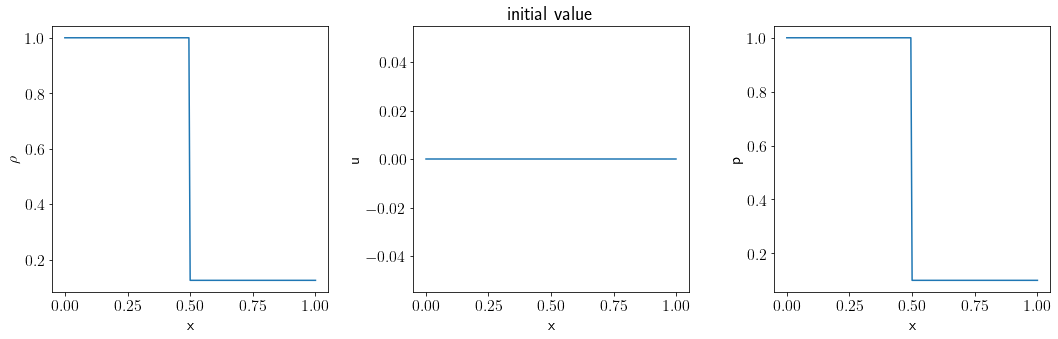

time step = 200, calculation time = 0.019999999999999934
time step = 400, calculation time = 0.04000000000000012
time step = 600, calculation time = 0.06000000000000069
time step = 800, calculation time = 0.08000000000000126
time step = 1000, calculation time = 0.10000000000000184
time step = 1200, calculation time = 0.12000000000000241
time step = 1400, calculation time = 0.1400000000000009


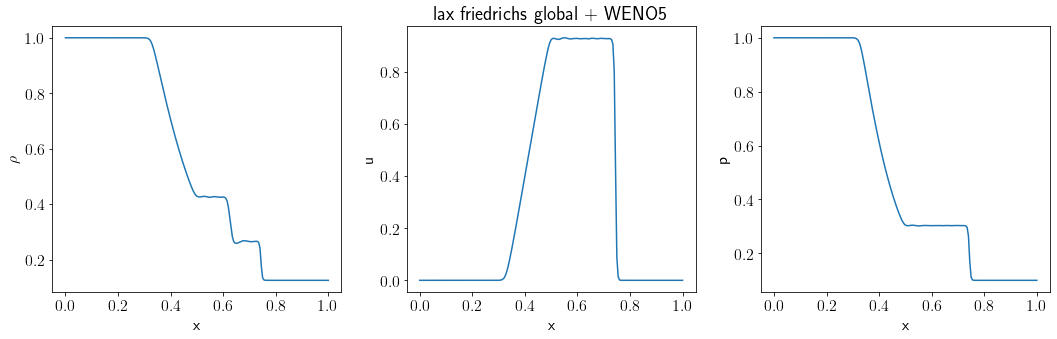

In [30]:
nx = 201        # grid number
tstep = 0       # time step
time_cal = 0    # calculation time 
time_end = 0.14 # end time: 0.14 for Sod and 1.8 for Shu-Osher
#time_end = 1.8  # end time: 0.14 for Sod and 1.8 for Shu-Osher
U, x = init_value(nx, init_type=0) # 0: Sod problem; 1: Shu-Osher problem
rho, u, p, c = primitive_var(U)
var_plot(x, rho, u, p, 'initial value')
dx = x[1] - x[0]
dt = 0.0001

NND = 1; WENO5 = 2
scheme_flag = 2
STEGER_WARMING = 1; LF_LOCAL = 2; LF_GLOBAL = 3
splitting_flag = 3
eigen_splitting_flag = 0 # 1 yes, 0 no; 激波解析很差，不知道哪里错了

if scheme_flag == NND: # 低精度格式得特征分裂，但是特征分裂代码有问题
    scheme_name = 'NND'
    KL = -1; KR = 3
elif scheme_flag == WENO5:
    scheme_name = 'WENO5'
    KL = -2; KR = 3

while time_cal < time_end:
    Un = U.copy() # conservative variables at the previous step
    for order_rk in range(1,4): # Runge-Kutta time marching
        rho, u, p, c = primitive_var(U)
        if splitting_flag == STEGER_WARMING:    # flux vector splitting
            splitting_name = 'steger warming'
            fp, fm = steger_warming_splitting(rho, u, c)
        elif splitting_flag == LF_LOCAL:
            splitting_name = 'lax friedrichs local'
            fp, fm = lax_friedrichs_local(rho, u, p, c, U)
        elif splitting_flag == LF_GLOBAL:
            splitting_name = 'lax friedrichs global'
            fp, fm = lax_friedrichs_global(rho, u, p, c, U)
        if eigen_splitting_flag == 1:           # difference scheme with eigen splitting
            fx = eigen_splitting(rho, u, c, fp, fm, scheme_flag, KL, KR)
        else:                                   # difference scheme without eigen splitting
            if scheme_flag == NND:               
                fpx = NND_pos(fp, KL, KR)
                fmx = NND_neg(fm, KL, KR)
            elif scheme_flag == WENO5:
                fpx = WENO5_pos(fp, KL, KR)
                fmx = WENO5_neg(fm, KL, KR)
            fx = fpx + fmx
        U = runge_kutta(Un, U, fx, dx, dt, order_rk, KL, KR)

        if order_rk == 3:
            time_cal += dt
            tstep += 1
    if tstep % 200 == 0:
        print('time step = {}, calculation time = {}'.format(tstep, time_cal))
        #rho, u, p, c = primitive_var(U)
        #var_plot(x, rho, u, p)

rho, u, p, c = primitive_var(U)
title = splitting_name + ' + ' + scheme_name
var_plot(x, rho, u, p, title)

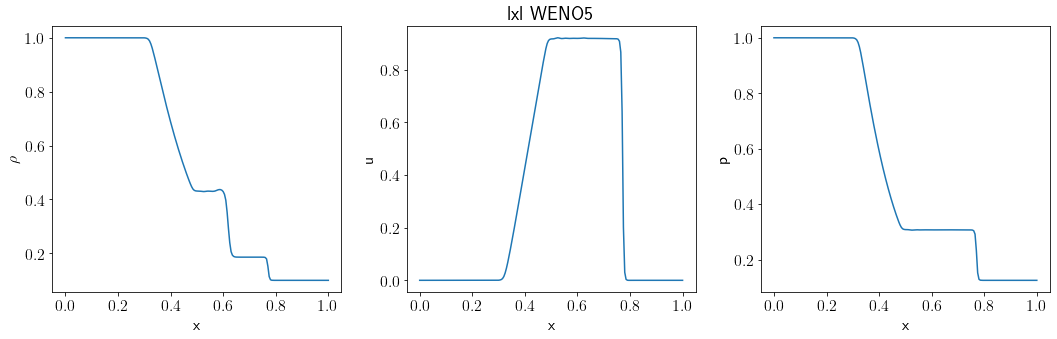

In [31]:
data = np.loadtxt('flow1d.dat')
x = data[:, 0]
rho = data[:, 1]
u = data[:, 2]
p = data[:, 3]
title = 'lxl WENO5'
var_plot(x, rho, u, p, title)